# Patches

path: /home/xionjing/CyroEM_segment

/home/xionjing/CyroEM_segment/T35_Rd2_FAP_Arm_2

---Image: T3EA83~1.png

/home/xionjing/CyroEM_segment/T35_Rd2_FAP_Arm_4

---Image: T3E06C~1.png

/home/xionjing/CyroEM_segment/T39_Rd2_FAP_Arm_A

---Image: T39 Rd2 FAP Arm_A_19-6-3-3_73000x.png
  
/home/xionjing/CyroEM_segment/T39_Rd2_FAP_Arm_B   

---Image: T39 Rd2 FAP Arm<font color='red'>_</font>B_8-1-2-4_73000x.png
  
You may need to add the underscore for those files. Because they are not named in the same fashion.

---

After running the **Step 1**, we will have another folder:


patches/ 

--- figure_name1

--- figure_name2

After running the **Step 1**, we will have the patch annotation:

patches/patch_folder_path(image name)/results.json

--- 

# Step 1:Make patches from a folder

In [18]:
import cv2
import json
import os
import re
import glob
from PIL import Image
import shutil

annotation_path = '/home/xionjing/CyroEM_segment/via_project_1Mar2023_full.json'
# path to save the patches
# YOU MAY WANT TO REPLACE THIS
path = '/home/xionjing/CyroEM_segment'
# png folder
# YOU MAY WANT TO REPLACE THIS
folder_path = '/home/xionjing/CyroEM_segment/val_unlabel/'

# Define the size of the patches and sliding window
patch_size = 768
slide_size = 384
resized_patch_size = 512

# ----------------------------------------

# Load the annotations
with open(annotation_path, 'r') as f:
    data = json.load(f)
    
# Indicate the folder of pictures
for filename in glob.glob(os.path.join(folder_path, '*.png')):
    base_filename = os.path.basename(filename)
    print(f"File: {base_filename}")
    
# well, I don't need to gather ground truth for it... annotation useless...

# ---------------------------------------

# make patches
for filename in glob.glob(os.path.join(folder_path, '*.png')):
    base_filename = os.path.basename(filename)
    image = cv2.imread(filename)
    
    #
    for i in range(0, image.shape[0], slide_size):
        for j in range(0, image.shape[1], slide_size):
            # Get the patch
            res_i = i
            res_j = j
            if i+patch_size <= image.shape[0] and j+patch_size <= image.shape[1]:
                patch = image[i:i+patch_size, j:j+patch_size]
            elif i+patch_size > image.shape[0] and j+patch_size <= image.shape[1]:
                patch = image[(image.shape[0]-patch_size):image.shape[0], j:j+patch_size]
                res_i = image.shape[0]-patch_size
            elif i+patch_size <= image.shape[0] and j+patch_size > image.shape[1]:
                patch = image[i:i+patch_size, (image.shape[1]-patch_size):image.shape[1]]
                res_j = image.shape[1]-patch_size
            elif i+patch_size > image.shape[0] and j+patch_size > image.shape[1]:
                patch = image[image.shape[0]-patch_size:image.shape[0], (image.shape[1]-patch_size):image.shape[1]]
                res_i = image.shape[0]-patch_size
                res_j = image.shape[1]-patch_size
            
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                print("pass")
                continue  # Skip patches that are not the correct size

            # Resize the patch
            patch = cv2.resize(patch, (resized_patch_size, resized_patch_size))

            # Save the patch
            patch_filename = f"{base_filename}_{res_i}_{res_j}.png"
            
            folder = f"{path}/patches/{base_filename}/"
            if not os.path.exists(folder):
                os.makedirs(folder)
            
            cv2.imwrite(f"{path}/patches/{base_filename}/{patch_filename}", patch)


File: T39_Rd2_FAP_Arm_A_16-5-2-3_73000x.png
File: T39 Rd2 FAP Arm_A_19-6-3-3_73000x.png
File: T35_Rd2_FAP_Arm_4_T3E06C~1.png
File: T39 Rd2 FAP Arm B_10-7-4-2_73000x.png
File: T35_Rd2_FAP_Arm_2_T3F42E~1.png


# Step 2: Obtain the bbox from the patches

In [49]:
# YOU MAY WANT TO REPLACE THIS
model_path = "/home/xionjing/CyroEM_segment/best.pt"
patch_folder_path_list = ["/home/xionjing/CyroEM_segment/patches/T35_Rd2_FAP_Arm_2_T3F42E~1.png/"]
origin_image_path_list = ["/home/xionjing/CyroEM_segment/T35_Rd2_FAP_Arm_2/T3F42E~1.png"]

import os 
from ultralytics import YOLO
import cv2
os.getcwd()
#load the model, You Only Look Once V8
model = YOLO(model_path)

### Now let's obtain one patch with it's bbox and visualize it


image 1/1 /home/xionjing/CyroEM_segment/Cocodataset/train/images/T39_Rd2_FAP_Arm_A_16-5-3-5_73000x_0_3072.png: 512x512 6 viruss, 14.0ms
Speed: 4.3ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 512)


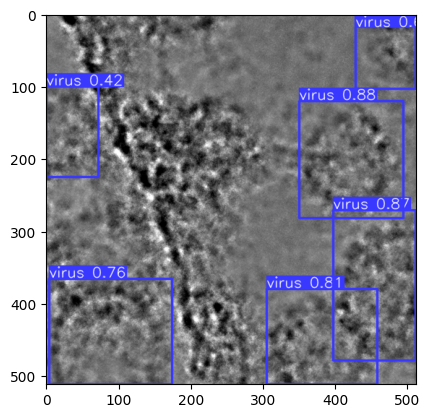

In [23]:
# YOU MAY WANT TO REPLACE THIS
img = "/home/xionjing/CyroEM_segment/Cocodataset/train/images/T39_Rd2_FAP_Arm_A_16-5-3-5_73000x_0_3072.png"
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
history = model.predict(img)[0]
image = history.plot()
plt.imshow(image)
plt.show()

In [53]:
# bbox data:
# x_min, y_min, width, height.
# same as Coco dataset
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

# Result: (in results.json)

{"figure.png": [
    {"class":0, # 0 for virus, 1 for ice, 2 for unsure
    "bbox":[1,2,3,4],
    "prob":0.8},
    {"class":1, 
    "bbox":[11,12,13,14],
    "prob":0.8},    
]}

# if 2 bbox has the same class, and they overlap, calculate the overlap area percentage to either of the bbox area. 
# And if the smaller size bbox's overlap area percentage (iou) is larger than 35% , remove the smaller size bbox.

{'figure.png': [{'class': 0, 'bbox': [1, 2, 3, 4], 'prob': 0.8},
  {'class': 1, 'bbox': [11, 12, 13, 14], 'prob': 0.8}]}

In [68]:
# Helper functions
import re

def format_boxes(boxes, resize = False, x_start = 0, y_start = 0):
    results = []
    for i in range(len(boxes.xyxy)):
        # convert from xyxy to xywh format
        x1, y1, x2, y2 = boxes.xyxy[i]
        
        if resize == True:
            # Resize the coordinates from 512 to 768
            x1, x2 = [x * (768 / 512) for x in [x1, x2]]
            y1, y2 = [y * (768 / 512) for y in [y1, y2]]

            # Add the start position
            x1 += x_start
            x2 += x_start
            y1 += y_start
            y2 += y_start
        
        width = x2 - x1
        height = y2 - y1
        
        # get the class and confidence score
        cls = int(boxes.cls[i].item())
        conf = float(boxes.conf[i].item())

        # add the result to the list
        results.append({
            "class": cls,
            "bbox": [int(x1), int(y1), int(width), int(height)],
            "prob": conf,
        })

    return results

def parse_filename(filename):
    # Regular expression pattern to extract name, xstart, and ystart
    pattern = r'^(.+)_(\d+)_(\d+)\.png$'

    match = re.match(pattern, filename)

    if match:
        name, x_start, y_start = match.groups()
        return name, int(x_start), int(y_start)

    else:
        raise ValueError(f"Filename {filename} doesn't match the expected format.")
        
def compute_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Compute the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1+w1, x2+w2)
    y_bottom = min(y1+h1, y2+h2)

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Compute areas
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2

    iou = intersection_area / (bbox1_area + bbox2_area - intersection_area)

    return iou

def compute_overlap_percentage(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    # Compute the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1+w1, x2+w2)
    y_bottom = min(y1+h1, y2+h2)

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Compute areas
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = w1 * h1
    bbox2_area = w2 * h2

    smaller_box_area = min(bbox1_area, bbox2_area)
    overlap_percentage = intersection_area / smaller_box_area

    return overlap_percentage

def remove_overlapping_boxes(data, iou_threshold=0.3, overlap_small_threshold = 0.24):
    for image, boxes in data.items():
        boxes.sort(key=lambda x: x['bbox'][2]*x['bbox'][3])  # Sort boxes by area (smaller first)
        
        # Compare each box with all other boxes and remove if it overlaps too much
        i = 0
        while i < len(boxes):
            box1 = boxes[i]
            
            j = i + 1
            while j < len(boxes):
                box2 = boxes[j]
                
                # Check if the boxes have the same class and overlap more than the threshold
                if box1['class'] == box2['class'] and compute_iou(box1['bbox'], box2['bbox']) > iou_threshold:
                    # If box1 is smaller than box2, remove box1
                    if box1['bbox'][2]*box1['bbox'][3] < box2['bbox'][2]*box2['bbox'][3]:
                        boxes.pop(i)
                        break  # Exit the inner loop and recheck box at index i
                    else:  # If box2 is smaller or equal, remove box2
                        boxes.pop(j)
                if box1['class'] == box2['class'] and compute_overlap_percentage(box1['bbox'], box2['bbox']) > overlap_small_threshold:
                    # If box1 is smaller than box2, remove box1
                    if box1['bbox'][2]*box1['bbox'][3] < box2['bbox'][2]*box2['bbox'][3]:
                        boxes.pop(i)
                        break  # Exit the inner loop and recheck box at index i
                    else:  # If box2 is smaller or equal, remove box2
                        boxes.pop(j)
                
                else:
                    j += 1
            
            else:  # Increment i only if the inner loop wasn't exited by 'break'
                i += 1
                
    return data

In [73]:
# Obtain the bbox from patches,
# then convert all of the boxes back the the original ones. 
# And then process the bbox
results_dict = {}
from glob import glob
for patch_folder_path in patch_folder_path_list:
    # Get all the images
    image_paths = glob(os.path.join(patch_folder_path, "*.png"))
    for image_path in image_paths:
        # Extract the y and x start positions from the filename
        filename = os.path.basename(image_path)
        name, y_start, x_start = parse_filename(filename)

        # Load image
        img = Image.open(image_path)

        # Run inference
        result = model(img)

        # Process the result
        boxes = result[0].boxes

        # Iterate over each detected bounding box
        bbox = format_boxes(boxes, resize = True, x_start = x_start, y_start = y_start)

        # Add to results dictionary
        if name not in results_dict.keys():
            results_dict[name] = bbox
        else:
            results_dict[name] = results_dict[name] + bbox

results_dict = remove_overlapping_boxes(results_dict, iou_threshold=0.3, overlap_small_threshold = 0.35)
print(len(results_dict[name]))
# Save to json file
with open(patch_folder_path + "results.json", "w") as f:
    json.dump(results_dict, f)


0: 512x512 2 viruss, 5 ices, 14.1ms
Speed: 1.8ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 viruss, 14.0ms
Speed: 1.5ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 virus, 1 ice, 14.0ms
Speed: 1.4ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 5 viruss, 2 ices, 14.0ms
Speed: 1.2ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 4 viruss, 2 ices, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 4 viruss, 4 ices, 14.0ms
Speed: 1.3ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 virus, 3 ices, 14.0ms
Speed: 1.4ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 virus, 4 ices, 1 unsure, 14.0ms
Speed: 1.3ms preprocess, 14


0: 512x512 3 viruss, 3 ices, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 viruss, 1 ice, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 viruss, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 viruss, 4 ices, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 3 viruss, 1 ice, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 viruss, 2 ices, 12.2ms
Speed: 1.1ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 5 viruss, 2 ices, 12.2ms
Speed: 1.2ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 viruss, 1 ice, 12.2ms
Speed: 1.2ms preprocess, 12.2ms infe

123


# Step 4: Visualization

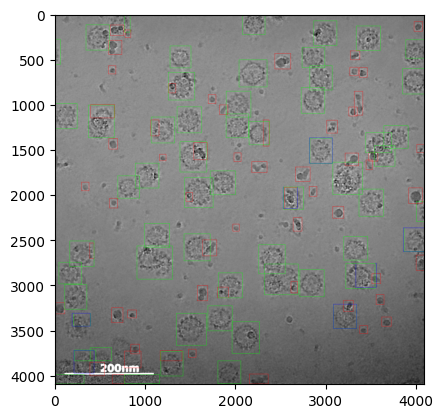

In [74]:
# Load the annotations
with open(patch_folder_path + "results.json", "r") as f:
    data = json.load(f)

for image_name1 in data.keys():
    image_name = image_name1
    img = cv2.imread(origin_image_path)

    # Make sure the image was successfully loaded
    if img is None:
        print(f'Failed to load image: {image_name}')
        continue

    annotations = []
    # Loop over all regions (bounding boxes)
    for region in data[image_name1]:
        shape_attr = region["bbox"]
        region_class = region["class"]
        region_prob = region["prob"]
        # Get the bounding box coordinates and scale up by a factor of 10
        x = shape_attr[0]
        y = shape_attr[1]
        width = shape_attr[2]
        height = shape_attr[3]

        # Append this annotation to the list
        annotations.append({
            "type": region_class,
            "bbox": [x, y, width, height],
            "prob": region_prob
        })
        
        # Set color according to class
        class_name = region_class
        if class_name == 0:
            color = (0, 255, 0)  # Green for virus
        elif class_name == 1:
            color = (255, 0, 0)  # Red for ice
        elif class_name == 2:
            color = (0, 0, 255)  # Blue for unsure
        else:
            color = (21, 255, 255)  # Blue for other classes

        # Draw the bounding box on the image
        top_left = (int(x), int(y))
        bottom_right = (int(x + width), int(y + height))
        thickness = 2  # Thickness of 2 px
        cv2.rectangle(img, top_left, bottom_right, color, thickness)


    # Save the image with bounding boxes
    output_filename = f'bbox_{image_name}'
    folder = patch_folder_path +  "bbox_prediction/" 
    if not os.path.exists(folder):
        os.makedirs(folder)
    cv2.imwrite(folder + "/" +output_filename, img)
    
    plt.imshow(img)
    plt.show()